# **Animal Competition (15%)**

> Indented block


For the non-competition mode, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals. 

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories. 

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network. 
*   How to use existing loss function for the model learning. 
*   Train the network on the training data. 
*   Test the trained network on the testing data. 

The following changes could be considered:

-------
1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out. 
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

Marking Rules:
-------
We will mark the competition based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark
###Acc_mark 10:

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

###Efficiency mark 10:

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

###Report mark 30:
Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks] 



In [107]:
##################################################################################################################################
### Subject: Computer Vision 
### Year: 2023
### Student Name: Kaifeng Yao, Yuehao Zheng
### Student ID: a1846570, a1869456
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC:95%         FLOPs:0.69G
##################################################################################################################################

In [2]:
# ! pip install tqdm

In [3]:
# Importing libraries. 

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Mounting G-Drive to get your dataset. 
# To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU. 
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 
# from google.colab import drive
# drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/Users/ky/Desktop/2024s1/cv/cv_a4/animal/dataset/dataset'
classes = os.listdir(data_dir)

In [5]:
# Performing Image Transformations. 
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])

In [6]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [7]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [8]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1745567..2.3031092].


Label:  ailurus-fulgens (5)


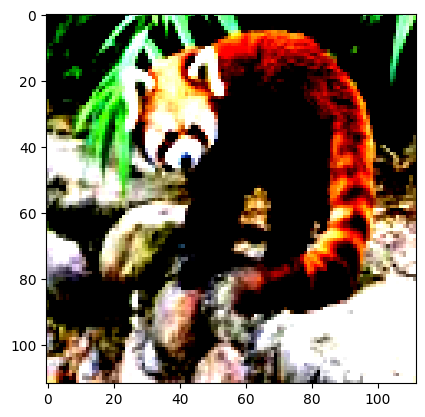

In [9]:
show_image(*dataset[200])

In [10]:
# Setting seed so that value won't change everytime. 
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [11]:
# Random Splitting.
# Note: Ensure no overlap between train, val and test sets.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(5330, 313, 627)

In [12]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader_o = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.2467773..2.3572743].


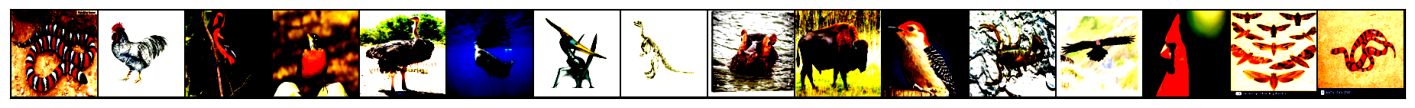

In [13]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

In [14]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [15]:
 # To check wether Google Colab GPU has been assigned/not. 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader_o = DeviceDataLoader(val_loader_o, device)
test_loader = DeviceDataLoader(test_loader, device)

In [17]:
input_size = 3*112*112
output_size = 151

In [18]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)
    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)
        
        return F.log_softmax(X, dim=1)

In [19]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
#model.cuda()

In [20]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)    
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([16, 3, 112, 112])
out.shape: torch.Size([16, 151])
out[0]: tensor([-5.0253, -5.0075, -4.9627, -5.0596, -5.0815, -4.9866, -5.0008, -4.9870,
        -5.0678, -5.0146, -5.0684, -4.9802, -4.9810, -5.0258, -5.0535, -5.0307,
        -5.0418, -5.0117, -5.0337, -5.0770, -5.0106, -5.0112, -5.0253, -4.9587,
        -4.9998, -4.9620, -4.9563, -5.0806, -5.0266, -4.9681, -4.9688, -5.0341,
        -5.0871, -5.0054, -5.0148, -4.9946, -5.0253, -4.9978, -4.9086, -5.0187,
        -5.0609, -5.0372, -5.0035, -5.0826, -4.9326, -5.0396, -5.0156, -5.0929,
        -5.0151, -5.0075, -5.0279, -5.0491, -4.9886, -5.0747, -5.0234, -5.0762,
        -5.0536, -5.0433, -5.0373, -4.9688, -5.0567, -5.0227, -5.0481, -5.0432,
        -5.0580, -4.9815, -5.0384, -5.0471, -5.0285, -5.0213, -5.0451, -5.0055,
        -5.0277, -5.0750, -5.0670, -5.0840, -5.0346, -4.9949, -5.0220, -4.9649,
        -5.0837, -5.0014, -5.0467, -4.9690, -4.9925, -4.9640, -5.0435, -5.0278,
        -5.0357, -5.0496, -5.0517, 

In [21]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader_o, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [22]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

In [23]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader_o):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader_o]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader_o, opt_func=torch.optim.SGD, early_stopping=None):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader_o)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        if early_stopping and early_stopping.should_stop(result['val_loss']):
            print("Early stopping at epoch:", epoch)
            break
        
    return history

In [24]:
model_Conv = to_device(model, device)

In [25]:
history0=[evaluate(model_Conv, val_loader_o)]
history0

[{'val_loss': 5.015639781951904, 'val_acc': 0.02187499962747097}]

In [26]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
lr = 0.001

627


In [27]:
# ! pip install ipywidgets

In [28]:
history0+= fit(num_epochs, lr, model_Conv, train_dl, val_dl, opt_func, early_stopping)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.7761, val_loss: 4.5437, val_acc: 0.0899


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.2330, val_loss: 4.1772, val_acc: 0.2184


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.7660, val_loss: 4.0301, val_acc: 0.2573


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.3614, val_loss: 3.8280, val_acc: 0.3066


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.9437, val_loss: 3.7424, val_acc: 0.3253


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.5645, val_loss: 3.8635, val_acc: 0.3410


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.1609, val_loss: 4.3929, val_acc: 0.3333


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.8424, val_loss: 4.5063, val_acc: 0.3559


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.5061, val_loss: 4.7636, val_acc: 0.3747


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.2467, val_loss: 5.0408, val_acc: 0.3566
Early stopping at epoch: 9


In [29]:
torch.save(model_Conv.state_dict(), r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\traning_data') 

In [30]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

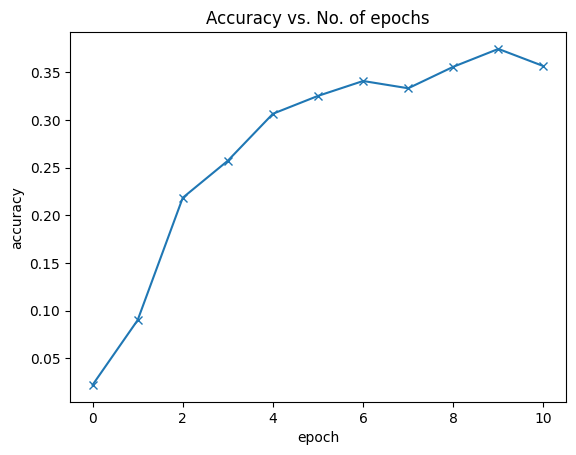

In [31]:
plot_accuracies(history0)

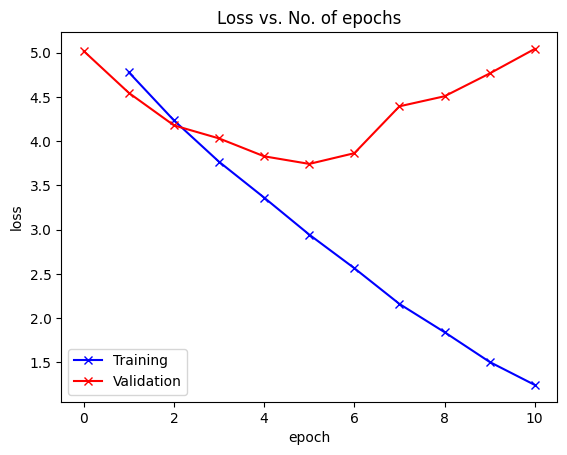

In [32]:
plot_losses(history0)

In [33]:
evaluate(model_Conv, test_loader)

{'val_loss': 4.872014045715332, 'val_acc': 0.38333332538604736}

## ResNet模型

In [34]:
# Data enhancement (training set)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Data enhancement (validation set)
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = '/Users/ky/Desktop/2024s1/cv/cv_a4/animal/dataset/dataset'  # Replace with local dataset path 

dataset = ImageFolder(data_dir, transform=train_transform)

torch.manual_seed(10)
val_size = len(dataset) // 20
test_size = len(dataset) // 10
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

val_ds.dataset.transform = val_transform
test_ds.dataset.transform = val_transform

# DataLoader
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        # maxk = max(topk)
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# Loading pre-trained ResNet models
class ResNetModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        for param in self.network.parameters():
            param.requires_grad = False
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.network(x)




In [38]:
num_classes = 151  
model_resnet = ResNetModel(num_classes)
model_resnet = to_device(model_resnet, device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD, early_stopping=None):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

        if early_stopping and early_stopping.should_stop(result['val_loss']):
            print("Early stopping at epoch:", epoch)
            break

    return history


In [39]:
num_epochs = 10 
opt_func = torch.optim.Adam
lr = 0.001
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
history1 = fit(num_epochs, lr, model_resnet, train_loader, val_loader, opt_func, early_stopping)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 2.1998, val_loss: 0.7572, val_acc: 0.9250


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.5693, val_loss: 0.6637, val_acc: 0.9500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.3508, val_loss: 0.6034, val_acc: 0.9563


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.2777, val_loss: 0.5316, val_acc: 0.9594


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.2113, val_loss: 0.6494, val_acc: 0.9375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.1779, val_loss: 0.5901, val_acc: 0.9531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1618, val_loss: 0.5322, val_acc: 0.9563


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1459, val_loss: 0.5829, val_acc: 0.9469


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.1259, val_loss: 0.5801, val_acc: 0.9406
Early stopping at epoch: 8


In [40]:
evaluate(model_resnet, test_loader)

{'val_loss': 0.3953953683376312, 'val_acc': 0.9781249761581421}

In [41]:
torch.save(model_resnet.state_dict(), r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\traning_data_Renet_model')

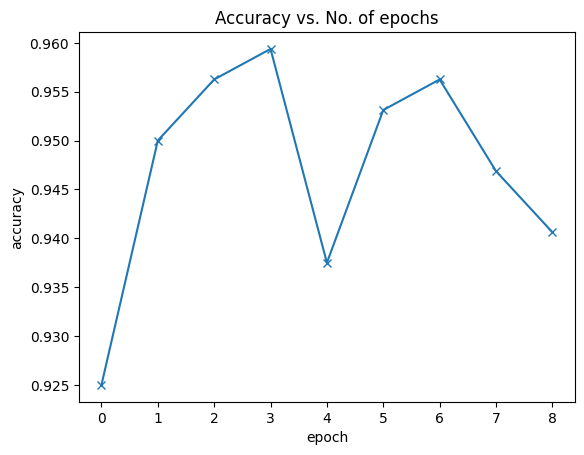

In [42]:
plot_accuracies(history1)

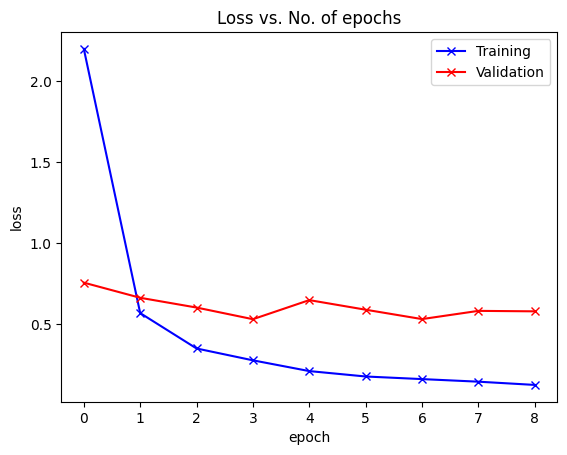

In [43]:
plot_losses(history1)

In [44]:
evaluate(model_resnet, test_loader)

{'val_loss': 0.3953953683376312, 'val_acc': 0.9781249761581421}

## Reduing FLOPS

In [45]:
tmodel = ConvolutionalNetwork(151).to(device)
tmodel.load_state_dict(torch.load(r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\traning_data')) 
tmodel.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=151, bias=True)
)

In [46]:
import torch.nn.utils.prune as prune

prune.ln_structured(tmodel.conv1, name='weight', amount=0.5, n=2, dim=0)
prune.ln_structured(tmodel.conv2, name='weight', amount=0.5, n=2, dim=0)
prune.ln_structured(tmodel.conv3, name='weight', amount=0.5, n=2, dim=0)
prune.ln_structured(tmodel.conv4, name='weight', amount=0.5, n=2, dim=0)
prune.ln_structured(tmodel.fc1, name='weight', amount=0.5, n=2, dim=0)

prune.remove(tmodel.conv1, 'weight')
prune.remove(tmodel.conv2, 'weight')
prune.remove(tmodel.conv3, 'weight')
prune.remove(tmodel.conv4, 'weight')
prune.remove(tmodel.fc1, 'weight')

torch.save(tmodel.state_dict(), r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\prune_model.pth')


In [47]:
input = torch.randn(1, 3, 112, 112).to(device)
pruned_model = ConvolutionalNetwork(151).to(device)
pruned_model.load_state_dict(torch.load(r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\prune_model.pth'))
pruned_model.eval()
evaluate(pruned_model, val_loader_o)

{'val_loss': 10.270088195800781, 'val_acc': 0.00937500037252903}

### ResNet Model

In [56]:
Rmodel = ResNetModel(num_classes).to(device)
Rmodel.load_state_dict(torch.load(r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\traning_data_Renet_model'))
Rmodel.eval()

ResNetModel(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [105]:
def resnet_prune_model(Rmodel):
    parameters_to_prune = (
        (Rmodel.network.layer1[0].conv1, 'weight'),
        (Rmodel.network.layer1[0].conv2, 'weight'),
        (Rmodel.network.layer2[0].conv1, 'weight'),
        (Rmodel.network.layer2[0].conv2, 'weight'),
        (Rmodel.network.layer3[0].conv1, 'weight'),
        (Rmodel.network.layer3[0].conv2, 'weight'),
        (Rmodel.network.layer4[0].conv1, 'weight'),
        (Rmodel.network.layer4[0].conv2, 'weight'),
        (Rmodel.network.fc, 'weight'),
    )
    for module, param in parameters_to_prune:
        prune.ln_structured(module, name=param, amount=0.5, n=2, dim=0)
        prune.remove(module, param)
    return Rmodel

resnet_pruned_model = resnet_prune_model(Rmodel)
torch.save(resnet_pruned_model.state_dict(), r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\traning_data_Renet_model')



In [94]:
# for name, param in resnet_pruned_model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data)


In [106]:
num_classes = 151
resnet_pruned_model = ResNetModel(num_classes).to(device)
resnet_pruned_model.load_state_dict(torch.load(r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\traning_data_Renet_model'))
# loaded_model = to_device(loaded_model, device)
resnet_pruned_model.eval()
evaluate(resnet_pruned_model, test_loader)

{'val_loss': 7.518927097320557, 'val_acc': 0.02968749962747097}

## FLOPs

In [60]:
import shutil

source = r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\FLOPs_counter.py'
destination = r'C:\Users\ky\Desktop\2024s1\cv'
shutil.copy(source, destination)

'C:\\Users\\ky\\Desktop\\2024s1\\cv\\FLOPs_counter.py'

In [ ]:
# ! pip install FLOPs_counter

## network

In [61]:
from FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model0 = ConvolutionalNetwork(num_classes)
print_model_parm_flops(model0, input, detail=False)

 + Number of FLOPs: 0.69G


In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pruned_model.to(device)
input = torch.randn(1, 3, 112, 112).to(device)
print_model_parm_flops(pruned_model, input, detail=False)

 + Number of FLOPs: 0.69G


In [108]:
class ConvolutionalNetwork_1(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes = classes
        self.conv1 = nn.Conv2d(3, 32, 5, 1)  # Reduced filters
        self.conv2 = nn.Conv2d(32, 64, 3, 1)  # Reduced filters
        self.conv3 = nn.Conv2d(64, 64, 3, 1)  # Reduced filters
        self.conv4 = nn.Conv2d(64, 64, 3, 1)  # Reduced filters
        self.fc1 = nn.Linear(64 * 5 * 5, self.num_classes)  # Adjusted input features

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 64 * 5 * 5)  # Adjusted input features
        X = self.fc1(X)
        return F.log_softmax(X, dim=1)


In [113]:
num_classes = 151
model3 = ConvolutionalNetwork_1(num_classes)
# model1.cuda()

# model1 = to_device(model1, device)
history3 = [evaluate(model3, val_loader_o)]
history3

history3 += fit(num_epochs, lr, model3, train_dl, val_dl, opt_func, early_stopping)


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.8061, val_loss: 4.6249, val_acc: 0.0931


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.1675, val_loss: 4.1412, val_acc: 0.2528


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.6000, val_loss: 3.8179, val_acc: 0.3271


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.0790, val_loss: 3.7599, val_acc: 0.3583


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.7042, val_loss: 3.6714, val_acc: 0.3753
Early stopping at epoch: 4


In [121]:
print_model_parm_flops(model3, input, detail=False)

 + Number of FLOPs: 0.20G


## Resnet

In [63]:
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model 
#Get the network and its FLOPs
num_classes = 151
model_resnet = ResNetModel(num_classes)
print_model_parm_flops(model_resnet, input, detail=False)

 + Number of FLOPs: 2.15G


In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_pruned_model.to(device)
input = torch.randn(1, 3, 112, 112).to(device)
print_model_parm_flops(resnet_pruned_model, input, detail=False)

 + Number of FLOPs: 2.15G


In [66]:
def count_nonzero_weights(model):
    non_zero_weights = sum(param.nonzero().size(0) for param in model.parameters())
    return non_zero_weights


In [67]:
print(count_nonzero_weights(model))
print(count_nonzero_weights(pruned_model))
print(count_nonzero_weights(resnet_pruned_model))

857239
427319
21748951


In [68]:
class ResNetModel_1(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.network = models.resnet18(pretrained=True)  # Use smaller pre-trained models: resnet18
        for param in self.network.parameters():
            param.requires_grad = False

        # Reducing the number of neurons in the fully connected layer
        self.network.fc = nn.Sequential(
            nn.Linear(self.network.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.network(x)


In [69]:
model1 = ResNetModel_1(num_classes)
# model1.cuda()

# model1 = to_device(model1, device)
history2 = [evaluate(model1, test_loader)]
history2
num_epochs = 10
early_stopping = EarlyStopping(patience=5, min_delta=0.01)
history2 += fit(num_epochs, lr, model1, train_loader, val_loader, opt_func, early_stopping)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.9594, val_loss: 2.1813, val_acc: 0.7132


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.3228, val_loss: 1.2986, val_acc: 0.8844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.8014, val_loss: 1.0465, val_acc: 0.9125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.4951, val_loss: 0.9381, val_acc: 0.9156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.3083, val_loss: 0.8098, val_acc: 0.9156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.2329, val_loss: 0.7872, val_acc: 0.9219


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.1307, val_loss: 0.7300, val_acc: 0.9281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.1174, val_loss: 0.6908, val_acc: 0.9500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.0700, val_loss: 0.6972, val_acc: 0.9375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.9968, val_loss: 0.6684, val_acc: 0.9375


In [71]:
torch.save(model1.state_dict(), r'C:\Users\ky\Desktop\2024s1\cv\cv_a4\traning_data1_resnet')

In [123]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1.to(device)
input = torch.randn(1, 3, 112, 112).to(device)

print_model_parm_flops(model1, input, detail=False)

 + Number of FLOPs: 0.20G


In [124]:
evaluate(model1, test_loader)

RuntimeError: shape '[-1, 1600]' is invalid for input of size 147456

## Final output

In [125]:
# Assuming history is defined elsewhere
best_val_acc0 = max(history0, key=lambda x: x['val_acc'])
best_val_acc1 = max(history1, key=lambda x: x['val_acc'])
best_val_acc2 = max(history2, key=lambda x: x['val_acc'])
best_val_acc2 = max(history3, key=lambda x: x['val_acc'])
best_val_acc_percentage0 = best_val_acc0['val_acc'] * 100
best_val_acc_percentage1 = best_val_acc1['val_acc'] * 100
best_val_acc_percentage2 = best_val_acc2['val_acc'] * 100
best_val_acc_percentage3 = best_val_acc2['val_acc'] * 100

# Code to calculate FLOPs
print(f"Best val_acc in ConvolutionalNetwork: {best_val_acc_percentage0:.2f}%")
print_model_parm_flops(pruned_model, input, detail=False)
print()
print(f"Best val_acc in ConvolutionalNetwork_1: {best_val_acc_percentage2:.2f}%")
print_model_parm_flops(model3, input, detail=False)
print()
print(f"Best val_acc in resnet: {best_val_acc_percentage1:.2f}%")
print_model_parm_flops(resnet_pruned_model, input, detail=False)
print()
print(f"Best val_acc in reset1: {best_val_acc_percentage2:.2f}%")
print_model_parm_flops(model1, input, detail=False)


Best val_acc in ConvolutionalNetwork: 37.47%
 + Number of FLOPs: 0.69G

Best val_acc in ConvolutionalNetwork_1: 37.53%
 + Number of FLOPs: 0.20G

Best val_acc in resnet: 95.94%
 + Number of FLOPs: 2.15G

Best val_acc in reset1: 37.53%
 + Number of FLOPs: 0.20G
